<a href="https://colab.research.google.com/github/RachelShalom/ai-for-medical-diagnostic/blob/master/Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# read the csv labels files from google drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)


Mounted at /content/gdrive/


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/data_files/')
# sys.path.append('/content/gdrive/data_files/')
sys.path.append('/content/gdrive/My Drive/data_process/')
# sys.path.append('/content/gdrive/data_process/')

## Download the Xray images

In [4]:
import download_files, datasets,loss,data_preprocess

In [5]:
download_files.dowbload_zip_files(3)

downloading images_01.tar.gz...
downloading images_02.tar.gz...
downloading images_03.tar.gz...
Download complete. Please check the checksums


In [6]:
!ls

gdrive	images_01.tar.gz  images_02.tar.gz  images_03.tar.gz  sample_data


In [ ]:
!tar -xvzf images_01.tar.gz
!tar -xvzf images_02.tar.gz
!tar -xvzf images_03.tar.gz
# !tar -xvzf images_04.tar.gz
# !tar -xvzf images_05.tar.gz

Streaming output truncated to the last 5000 lines.
images/00003489_011.png
images/00003535_003.png
images/00002856_014.png
images/00001986_006.png
images/00002369_000.png
images/00002457_001.png
images/00001931_021.png
images/00003689_002.png
images/00001652_001.png
images/00002058_020.png
images/00001912_005.png
images/00003527_000.png
images/00003615_001.png
images/00002466_005.png
images/00003109_003.png
images/00001816_001.png
images/00002964_000.png
images/00002119_002.png
images/00002374_000.png
images/00003122_006.png
images/00001741_003.png
images/00001900_030.png
images/00003188_004.png
images/00003871_000.png
images/00002383_004.png
images/00001895_002.png
images/00002538_000.png
images/00001888_000.png
images/00003923_010.png
images/00001733_000.png
images/00003281_000.png
images/00001821_001.png
images/00002463_002.png
images/00002208_004.png
images/00003459_021.png
images/00002547_004.png
images/00003528_038.png
images/00003779_005.png
images/00002375_001.png
images/000019

In [ ]:
import os
print(f"There are  {len(os.listdir('images'))} images")

### Read the data file with user metadata


In [ ]:
base_dir="/content/gdrive/My Drive/"

# get the data lbels and user metadata
data=pd.read_csv(f"{base_dir}data_files/Data_Entry_2017_v2020.csv")
data.head()

## Convert to binary labels 
the goal is to predict wehather each of those pathologies  are present (i.e. positive result) or absent (i.e. negative result) Let's convert the labels to binary labels


In [ ]:
binary_labels=data_preprocess.save_binary_labels(read_path=f"{base_dir}data_files/Data_Entry_2017_v2020.csv",save_path=f"{base_dir}data_files/binary_labels.csv")



In [ ]:
# since I only downloaded part of the images- let's save updated file with the dowlowded image as"currentl labels"
data_preprocess.save_current_labels(binary_labels,read_path="images",save_path=f"{base_dir}data_files/current_labels.csv")

In [ ]:

current_labels=pd.read_csv(f"{base_dir}data_files/current_labels.csv")
current_labels["binary_labels"]=np.abs(current_labels["No Finding"]-1)
current_labels.to_csv(f"{base_dir}data_files/current_labels.csv",index=False)
current_labels.head()

## Split to test, Train and val by groups (groups are users) making sure there is no dataleak.i.e. same user image in both train and val or test

In [ ]:
data_preprocess.split_data_and_save(file_name=f"{base_dir}data_files/current_labels.csv",n=5,files_to_save=[f"{base_dir}data_files/train.csv",f"{base_dir}data_files/test.csv"])
data_preprocess.split_data_and_save(file_name=f"{base_dir}data_files/test.csv",n=5,files_to_save=[f"{base_dir}data_files/test.csv",f"{base_dir}data_files/val.csv"])
train=pd.read_csv(f"{base_dir}data_files/train.csv")
test=pd.read_csv(f"{base_dir}data_files/test.csv")
val=pd.read_csv(f"{base_dir}data_files/val.csv")



In [ ]:
print(train.shape,test.shape,val.shape)
train.head()

## Balance of Labels
- looks like majority is negative

In [ ]:
# Let's check frquexncy of each class:
label_names = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation','No Finding']  
label_names_short=list(set(label_names)-set(["No Finding"]))          
import matplotlib.pyplot as plt          
plt.xticks(rotation=90)
plt.bar(x=label_names, height=np.mean(train[label_names], axis=0))
plt.title("Frequency of Each Class")
plt.show()

plt.xticks(rotation=90)
plt.bar(x=label_names_short, height=np.mean(train[label_names_short], axis=0))
plt.title("Frequency of Each Class excluding no findings" )
plt.show()

In [ ]:
#Frequency of positive and negative in each class
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each

   """
    N=labels.shape[0]
    positive_frequencies=np.sum(labels,axis=0)/N
    negative_frequencies=1-positive_frequencies
    return positive_frequencies,negative_frequencies

                        

## Computing the positive negative frequencies for each class show that there are very little positives labels for each class

In [ ]:
#How many unique users do we have?
positive_frequencies,negative_frequencies=compute_class_freqs(train[label_names_short])

In [ ]:
data_pos=pd.DataFrame({"class":positive_frequencies.index,"label":"positive","values":positive_frequencies.values})
data_neg=pd.DataFrame({"class": negative_frequencies.index,"label":" negative","values": negative_frequencies.values})
all_data=data_pos.append(data_neg)
import seaborn as sns
plt.xticks(rotation=90)
f=sns.barplot(x="class",y="values",hue="label",data=all_data)

one way to fix that  is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.
To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$
which we can do simply by taking

$$w_{pos} = freq_{neg}$$$$w_{neg} = freq_{pos}$$
This way, we will be balancing the contribution of positive and negative labels.

In [ ]:
pos_weights = negative_frequencies
neg_weights = positive_frequencies
pos_contribution = positive_frequencies * pos_weights 
neg_contribution = negative_frequencies * neg_weights

In [ ]:
# Let's check that it works
data_pos=pd.DataFrame({"class":pos_contribution.index,"label":"positive","values":pos_contribution.values})
data_neg=pd.DataFrame({"class": neg_contribution.index,"label":" negative","values": neg_contribution.values})
all_data=data_pos.append(data_neg)
plt.xticks(rotation=90)
f=sns.barplot(x="class",y="values",hue="label",data=all_data)

## Weighted Loss
As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [ ]:
L=xray_dataset.get_weighted_loss(pos_weights,neg_weights)

## Data preparation
Transformations,Dataset and Dataloader

In [ ]:
trans=transforms.Compose([transforms.CenterCrop(700),transforms.ToTensor()])

In [144]:
from torch.utils.data import DataLoader

train_dataset=datasets.XrayDataSet(csv_file=f"{base_dir}data_files/train.csv",label_names=label_names_short,root_dir="images",transform=trans)
test_dataset=datasets.XrayDataSet(csv_file=f"{base_dir}data_files/test.csv",label_names=label_names_short,root_dir="images",transform=transforms.ToTensor())
val_dataset=datasets.XrayDataSet(csv_file=f"{base_dir}data_files/val.csv",label_names=label_names_short,root_dir="images",transform=transforms.ToTensor())

train_loader=DataLoader(train_dataset,batch_size=16,num_workers=0,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=16,num_workers=0,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=16,num_workers=0,shuffle=False)

In [1]:
index_to_label={label_names.index(l):l for l in label_names[:-1]}

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
def show_transformed_images(loader=train_loader):
  fig = plt.figure(figsize=(14,10))

  dataiter = iter(loader)
  images, labels = dataiter.next()
    # print(images.shape)

  # show images # Let us show some of the training images, for fun.
  imshow(torchvision.utils.make_grid(images[0:5,:,:,:]))
  names=[]
  for i in range(labels[:5].shape[0]):
    idx=(labels[i]==1).nonzero()
    if len(idx)==0:
      names.append("No findings")
    else:
      d=[]
      for i in range(idx.shape[0]):
        d.append(index_to_label[idx[i].item()])
      names.append(d)  
  plt.title(names)

NameError: ignored

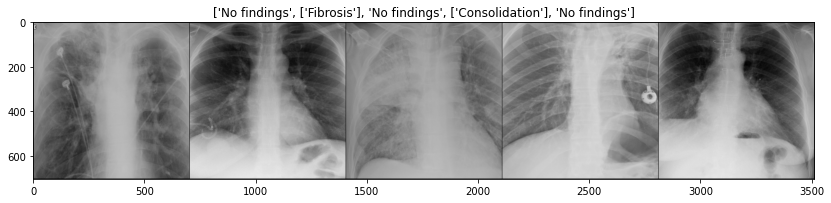

In [146]:
show_transformed_images()

In [96]:
lr=0.001
BATCH_SIZE=16
save_path=None
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
transform=transforms.Compose([transforms.Resize(256),
transforms.TenCrop(224))
    # optimizer = optim.SGD(filter(lambda p: p.requires_grad, self.net.parameters()),
    #                 lr=LR, momentum=0.9)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.net.parameters()), lr=LR)




SyntaxError: ignored

In [87]:
index_to_label

{0: 'Cardiomegaly',
 1: 'Emphysema',
 2: 'Effusion',
 3: 'Hernia',
 4: 'Infiltration',
 5: 'Mass',
 6: 'Nodule',
 7: 'Atelectasis',
 8: 'Pneumothorax',
 9: 'Pleural_Thickening',
 10: 'Pneumonia',
 11: 'Fibrosis',
 12: 'Edema',
 13: 'Consolidation'}